<h1 style='text-align: center;'>TP2</h1>
<h1 style='text-align: center;'>Réseau Neuronal Convolutif en utilisant Pytorch </h1>

# Connexion de Kaggle à Google Colab et téléchargement de jeux de données à partir de Kaggle vers le serveur de Google Colab.

In [ ]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c digit-recognizer

 65% 10.0M/15.3M [00:00<00:00, 21.5MB/s]
100% 15.3M/15.3M [00:00<00:00, 34.0MB/s]


# Décompressez le jeu de données installé.

In [ ]:
!unzip /content/digit-recognizer.zip

Archive:  /content/digit-recognizer.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


## les différentes bibliothèques utilisées.

In [ ]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
import torch.optim as optim

import os
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Lecture de jeux données

In [ ]:
if not os.path.exists("data"):
    os.makedirs("data")

In [ ]:
df = pd.read_csv("data/train.csv")
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Next, extract numeric values which represent intensities (excluding column 0), compute the maximum value for use in normalization later, and jot down the total number of examples.

In [ ]:
def cube_data(df):
    """Creates an n-d array from data frame"""
    if "label" in df.columns:
        imgs = df.drop("label", axis = 1).values # iloc: integer indexing, values: numpy ndarray
    else:
        imgs = df.values
    ntot = imgs.shape[0]         # number of rows

    imgs = imgs / 255
    # create a ntrain * 28 * 28 ndarray of training set
    cube = np.ndarray(shape = (ntot, 1, 28, 28), dtype = "float")
    for i in range(0, ntot):
        cube[i, 0, :, :] = imgs[i, :].reshape(28, 28)
    return cube

In [ ]:
cube = cube_data(df)
ntot = cube.shape[0]

Split the data into a 60/40 training and validation set.

In [ ]:
ntrain = np.floor(ntot * .6)
train_indices = np.random.randint(0, int(ntot), size = int(ntrain))

nvalid = ntot - ntrain
valid_indices = np.setdiff1d(list(range(0, ntot)), train_indices)

## Cubing the training data

We've got to un-unroll the data into a 4d numpy array and create our vector of labels, divided into training and validation sets.

(array([27182695.,   399808.,   359330.,   306344.,   312800.,   363558.,
          317852.,   362706.,   427725.,  2895182.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

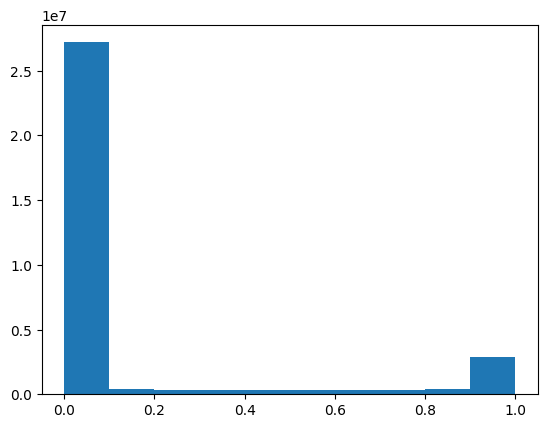

In [ ]:
plt.hist(cube.flatten())

In [ ]:
# Create a tensor containing the correct labels
labels = df['label'].values

# Séparer les données en ensembles d'entraînement et de validation

In [ ]:

train_cube = torch.FloatTensor(cube[train_indices, :, :, :])
valid_cube = torch.FloatTensor(cube[valid_indices, :, :, :])

train_labels = torch.from_numpy(labels[train_indices])
valid_labels = torch.from_numpy(labels[valid_indices])

In [ ]:
print(train_cube.size())
print(train_labels.size())
print(valid_cube.size())
print(valid_labels.size())

torch.Size([25200, 1, 28, 28])
torch.Size([25200])
torch.Size([23147, 1, 28, 28])
torch.Size([23147])


## Création des data loaders

In [ ]:
trainset = torch.utils.data.TensorDataset(train_cube, train_labels)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 16,
                                          shuffle = True, num_workers = 4)

testset = torch.utils.data.TensorDataset(valid_cube, valid_labels)
testloader = torch.utils.data.DataLoader(testset, batch_size = 16,
                                          shuffle = True, num_workers = 4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


#  Création de la classe de modèle CNN  sur PyTorch.

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 120)
        self.fc1_drop = nn.Dropout()
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1_drop(self.fc1(x)))
        x = F.relu(self.fc2(x))
        return F.log_softmax(x)

    def num_flat_features(self, x):
        size = x.size()[1:] # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

net = Net()
net

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=120, bias=True)
  (fc1_drop): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=120, out_features=10, bias=True)
)

In [ ]:
params = list(net.parameters())
print(len(params))
print(params[0].size())
print(params[2].size())
print(params[4].size())

8
torch.Size([10, 1, 5, 5])
torch.Size([20, 10, 5, 5])
torch.Size([120, 320])


# Sélection de l'optimiser pour la decente de gradient

In [ ]:
optimizer = optim.Adam(net.parameters())

# Fonction d'entrainement

In [ ]:
def train(epoch):
    net.train()
    for batch_index, (inputs, labels) in enumerate(trainloader):
        inputs, labels = Variable(inputs), Variable(torch.squeeze(labels))
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = F.nll_loss(outputs, labels)
        loss.backward()
        optimizer.step()
        if batch_index % 400 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_index * len(inputs), len(trainloader.dataset),
                    100. * batch_index / len(trainloader), loss))


# Fonction de test

In [ ]:
def test(epoch):
    net.eval()
    test_loss = 0
    correct = 0
    for data, target in testloader:
        data, target = Variable(data, volatile=True), Variable(torch.squeeze(target))
        output = net(data)
        test_loss += F.nll_loss(output, target)
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    test_loss = test_loss
    test_loss /= len(testloader) # loss function already averages over batch size
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))

# Entrainement du modèle et évaluation

In [ ]:
for epoch in range(4): # loop over the dataset multiple times
    train(epoch)
    test(epoch)

<ipython-input-22-221124428fe5>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 0 [0/25200 (0%)]	Loss: 2.301285
Train Epoch: 0 [6400/25200 (25%)]	Loss: 0.676508
Train Epoch: 0 [12800/25200 (51%)]	Loss: 0.142550
Train Epoch: 0 [19200/25200 (76%)]	Loss: 0.304638


<ipython-input-26-3dbff50592b3>:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(torch.squeeze(target))



Test set: Average loss: 0.1449, Accuracy: 22132/23147 (96%)

Train Epoch: 1 [0/25200 (0%)]	Loss: 0.533372
Train Epoch: 1 [6400/25200 (25%)]	Loss: 0.281450
Train Epoch: 1 [12800/25200 (51%)]	Loss: 0.076187
Train Epoch: 1 [19200/25200 (76%)]	Loss: 0.162065

Test set: Average loss: 0.1107, Accuracy: 22372/23147 (97%)

Train Epoch: 2 [0/25200 (0%)]	Loss: 0.103177
Train Epoch: 2 [6400/25200 (25%)]	Loss: 0.008659
Train Epoch: 2 [12800/25200 (51%)]	Loss: 0.024414
Train Epoch: 2 [19200/25200 (76%)]	Loss: 0.012425

Test set: Average loss: 0.0950, Accuracy: 22468/23147 (97%)

Train Epoch: 3 [0/25200 (0%)]	Loss: 0.203974
Train Epoch: 3 [6400/25200 (25%)]	Loss: 0.573009
Train Epoch: 3 [12800/25200 (51%)]	Loss: 0.091100
Train Epoch: 3 [19200/25200 (76%)]	Loss: 0.053847

Test set: Average loss: 0.0796, Accuracy: 22597/23147 (98%)



## Prediction pour les données du test


In [ ]:
test_df = pd.read_csv("data/test.csv")
test_cube = cube_data(test_df)
ntest = test_cube.shape[0]
test_cube = torch.FloatTensor(test_cube)

In [ ]:
pred = net(Variable(test_cube))

<ipython-input-22-221124428fe5>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [ ]:
type(pred)

torch.Tensor

In [ ]:
_, predicted = torch.max(pred, 1)

In [ ]:
predicted

tensor([2, 0, 9,  ..., 3, 9, 2])